In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_WIDTH = 224
IMG_HEIGHT = 224

# pre-trained model Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

# user-defined classifier ===============
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

# 정답은 cat or dog 2개이므로 출력층 노드는 2개
model.add(Dense(2, activation='softmax'))
# =======================================

model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non

In [2]:
dir_path = '/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/cats_and_dogs_filtered'
train_dir = dir_path + '/train'
test_dir = dir_path + '/validation'

train_data_gen = ImageDataGenerator(rescale=1./255, # 이미지를 읽어올 떄 자동으로 정규화됨
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)
test_data_gen = ImageDataGenerator(rescale=1./255) # 이미지를 읽어올 떄 자동으로 정규화됨

train_data = train_data_gen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle=True,
                                                class_mode='categorical', # categorical 이므로 정답은 ont-hot encoding 정의됨
                                                target_size=(IMG_WIDTH, IMG_HEIGHT))
test_data = test_data_gen.flow_from_directory(test_dir, 
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle=True,
                                                class_mode='categorical', # categorical 이므로 정답은 ont-hot encoding 정의됨
                                                target_size=(IMG_WIDTH, IMG_HEIGHT))

print(train_data.class_indices.items())
print(test_data.class_indices.items())

# Fine-Tuning 은 학습율을 낮게(2e-5) 설정해서 pre-trained weights 를 조금씩 업데이트 해주는 것이 핵심
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(train_data, epochs=30, validation_data=test_data, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.5372 - accuracy: 0.6485
Epoch 1: val_loss improved from inf to 0.30084, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 1213s 19s/step - loss: 0.5372 - accuracy: 0.6485 - val_loss: 0.3008 - val_accuracy: 0.9100
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8820
Epoch 2: val_loss improved from 0.30084 to 0.12104, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 51s 811ms/step - loss: 0.3106 - accuracy: 0.8820 - val_loss: 0.1210 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9175
Epoch 3: val_loss improved from 0.12104 to 0.07590, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 48s 754ms/step - loss: 0.2072 - accuracy: 0.9175 - val_loss: 0.0759 - val_accuracy: 

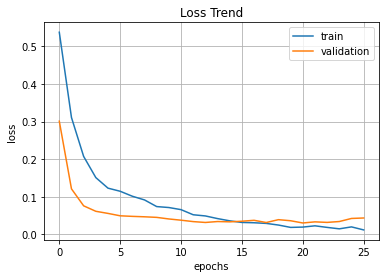

In [4]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

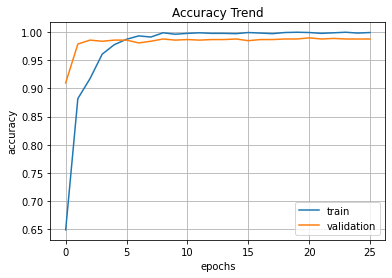

In [5]:
plt.title('Accuracy Trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

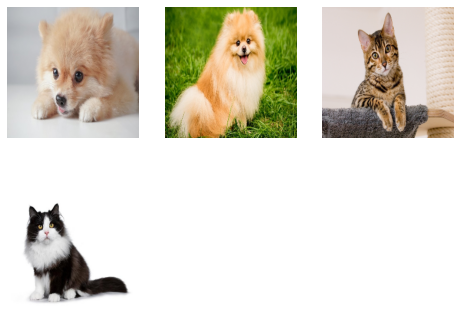

In [6]:
import cv2
import glob

test_img_list = []
test_img_name_list = glob.glob('/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/test/**/*') # 테스트 이미지 파일이름 리스트

for i in range(len(test_img_name_list)):
  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
  src_img = cv2.resize(src_img, dsize=(224, 224))
  dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(2, 3, i + 1)
  plt.axis('off')
  plt.imshow(test_img_list[i])

plt.show()

In [7]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


1/1 [==============================] - 2s 2s/step


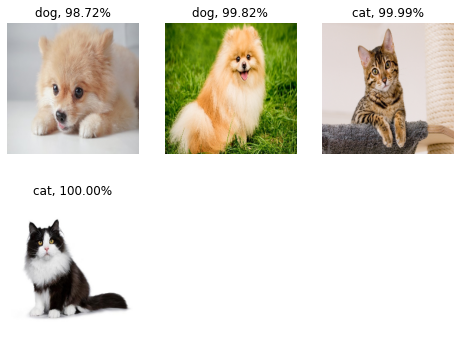

In [8]:
import numpy as np

pred = model.predict(np.array(test_img_list)) # batch 차원을 추가하여 predict 실행 (batch_size, width, height, channel)

class_name = ['cat', 'dog']

plt.figure(figsize=(8,6))

for i in range(len(pred)):
  plt.subplot(2, 3, i + 1)
  prediction = str(class_name[np.argmax(pred[i])])
  probility = '{0:0.2f}'.format(100*max(pred[i]))
  title_str = prediction + ', ' + probility + '%'
  plt.axis('off')
  plt.title(title_str)
  plt.imshow(test_img_list[i])

plt.show()